In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [28]:
def tensor_to_image(tensor):
    tensor = tensor*255                           ## to convert float values to image pixel values
    tensor = np.array(tensor, dtype=np.uint8)     ## convert it into np array with int values
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1               ## if the array has 3 dim but 1st dim is only 1 then we remove it
        tensor = tensor[0]
    
    return PIL.Image.fromarray(tensor)            ## return an image from the array

In [7]:
## Downloading a style and content image:

content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 2us/step


## Visualising the input

In [46]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)              ## read the image in a tensor form
    img = tf.image.decode_image(img, channels=3)    ## convert the tensor from the path to an image
    img = tf.image.convert_image_dtype(img, tf.float32)   ## convert image from int [0 to 255] to float [0 to 1)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)  ## type casting shape from int to float
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)     ## scaling down the image shape to 512 max dim..

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]                        ## adding a new axis
    return img

In [49]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)       ## reducing the 1 extra axis added

    plt.imshow(image)
    if title:
        plt.title(title)

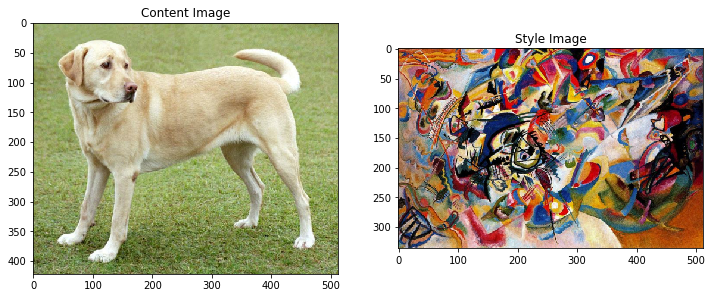

In [50]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Fast Style Transfer using TF-Hub 

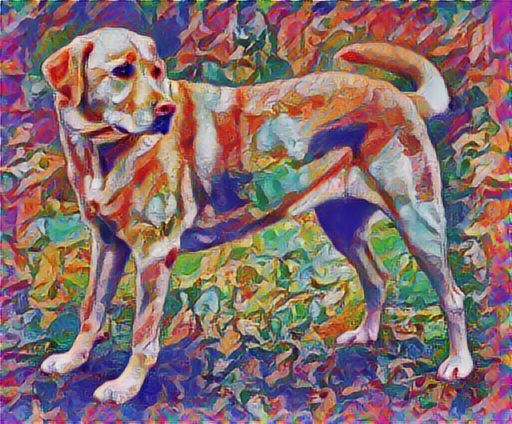

In [22]:
## Using hub on pretrained module to get the result image. 

import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]   ## takes the images as tensors
tensor_to_image(stylized_image)

## Define content and style representations

In [23]:
## Loading a VGG19 CNN model to predict the content image
## Use the intermediate layers of the model to get the content and style representations of the image.

x = tf.keras.applications.vgg19.preprocess_input(content_image*255)     ## converting image to int from float
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')  ## loading a VGG19 with imagenet weights
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 1033s 2us/step


TensorShape([1, 1000])

In [58]:
## printing the top 5 probabilites

predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Labrador_retriever', 0.49317262),
 ('golden_retriever', 0.23665187),
 ('kuvasz', 0.036357313),
 ('Chesapeake_Bay_retriever', 0.024182774),
 ('Greater_Swiss_Mountain_dog', 0.018646035)]

In [25]:
## Loading a VGG19 Model with imagenet weights.

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)

80142336/80134624 [==============================] - 67s 1us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [59]:
## Choose intermediate layers from the network to represent the style and content of the image:

# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)